In [1]:
"""
Finding matching ICS records for NIFC perimeters.

Author: maxwell.cook@colorado.edu
"""

import os, sys
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.spatial import cKDTree
from shapely.geometry import Point

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')
icsdir = os.path.join(maindir, 'ics209-plus-fired/data/')

print("Ready !")

Ready !


In [2]:
# Load some boundary data
states = os.path.join(maindir, 'data/boundaries/political/TIGER/tl19_us_states_w_ak_lambert.gpkg')
states = gpd.read_file(states)
states = states.to_crs(proj)
states.columns

Index(['REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS', 'NAME',
       'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')

In [3]:
# Functions !

def best_match(perim, neighbors, max_size_diff):
    # Get the fire size from the perimeter data
    perim_size = perim['GIS_ACRES']

    # Initialize best score and match
    best_score = float('inf')
    best_match = None
    
    for _, point in neighbors.iterrows():
        # Calculate the size difference
        ics_size = point.get('FINAL_ACRES', np.nan)
        
        if perim_size != 0:
            size_diff = abs((ics_size - perim_size) / perim_size) * 100
        else:
            size_diff = float('inf')  # If perim_size is 0, treat it as infinite difference

        if max_size_diff is not None:
            if size_diff > max_size_diff:
                continue  # Skip if size difference exceeds max_size_diff
        
        # Calculate the spatial distance (assuming it's precomputed)
        spatial_dist = point.get('spatial_dist', 0)
        
        # Composite score (you can adjust the weights as needed)
        score = spatial_dist + size_diff
        
        # Check if this is the best match
        if score < best_score:
            best_score = score
            best_match = point
    
    return best_match


def find_nearest(perims, points, NN, max_dist=50000, max_size_diff=150):
    """ 
    Finds the N nearest points based on spatial proximity and temporal alignment.
    """

    out_nns = []  # storing the resulting nearest neighbors for each perimeter
    no_matches = []  # to store fires with no matches
    
    for _, perim in perims.iterrows():
        fire_id = perim['OBJECTID']
        perim_geom = perim.geometry
        fire_year = perim['FIRE_YEAR']

        # Filter incident points to the fire year (filtered once per perimeter)
        inci_points = points[points['START_YEAR'] == fire_year]

        # Early check if no points match the fire year
        if inci_points.empty:
            print(f"No matching points for fire year and fire id: {fire_year} / {fire_id}")
            no_matches.append(perim.to_frame().T)  # Append as DataFrame
            continue

        # Calculate distances from the fire perimeter to the incident points
        distances = inci_points.geometry.apply(lambda x: perim_geom.distance(x))

        # Filter by the maximum distance if provided
        if max_dist is not None:
            inci_points = inci_points[distances <= max_dist]
            distances = distances[distances <= max_dist]

        # Check if there are still points left after filtering
        if inci_points.empty:
            no_matches.append(perim.to_frame().T)  # Convert row to DataFrame and append
            continue

        # Sort by distance and retain the nearest NN points
        nearest_points = inci_points.iloc[distances.argsort()[:NN]].copy()

        # Calculate the best match based on size and distance
        best_ = best_match(perim, nearest_points, max_size_diff=max_size_diff)

        if best_ is not None:
            best_['NIFC_ID'] = perim['OBJECTID']
            best_['NIFC_NAME'] = perim['INCIDENT']
            best_['NIFC_ACRES'] = perim['GIS_ACRES']
            out_nns.append(best_.to_frame().T)  # Convert best match to DataFrame before appending
        
    # Concatenate the no_matches 
    print(f"There were [{len(no_matches)}/{len(perims)}] fires with no matches.")
    if len(no_matches) > 0:
        no_matches = pd.concat(no_matches, ignore_index=True)
    else:
        no_matches = pd.DataFrame()

    # Concatenate the matches
    if len(out_nns) > 0:
        out_nns = pd.concat(out_nns, ignore_index=True)
    else:
        out_nns = pd.DataFrame()

    return out_nns, no_matches


print("Functions ready for use !")

Functions ready for use !


In [4]:
# Load the wildfire dataset
inci_path = os.path.join(icsdir, 'tabular/raw/wf-incidents/ics209-plus_v3.2/ics209-plus-wf_incidents_1999to2023.csv')
incidents = pd.read_csv(inci_path, low_memory=False)
incidents.columns

Index(['Unnamed: 0', 'INCIDENT_ID', 'INCIDENT_NUMBER', 'INCIDENT_NAME',
       'INCTYP_ABBREVIATION', 'FINAL_ACRES', 'CAUSE', 'COMPLEX',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'EXPECTED_CONTAINMENT_DATE',
       'FATALITIES', 'FUEL_MODEL', 'INCIDENT_DESCRIPTION', 'INC_IDENTIFIER',
       'INJURIES_TOTAL', 'LL_CONFIDENCE', 'LL_UPDATE', 'LOCAL_TIMEZONE',
       'POO_CITY', 'POO_COUNTY', 'POO_LATITUDE', 'POO_LONGITUDE',
       'POO_SHORT_LOCATION_DESC', 'POO_STATE', 'PROJECTED_FINAL_IM_COST',
       'START_YEAR', 'SUPPRESSION_METHOD', 'STR_DAMAGED_TOTAL',
       'STR_DAMAGED_COMM_TOTAL', 'STR_DAMAGED_RES_TOTAL',
       'STR_DESTROYED_TOTAL', 'STR_DESTROYED_COMM_TOTAL',
       'STR_DESTROYED_RES_TOTAL', 'FATALITIES_RESPONDER', 'FATALITIES_PUBLIC',
       'FINAL_REPORT_DATE', 'INCIDENT_ID_OLD', 'INC_MGMT_NUM_SITREPS',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'STR_THREATENED_MAX',
       'STR_THREATENED_COMM_MAX', 'STR_THREATENED_RES_MAX', 'TOTAL_AERIAL_SUM',
       'TOTAL_PERSON

In [5]:
# Tidy the columns
incidents.dropna(subset=['DISCOVERY_DATE'], inplace=True)
incidents['DISCOVERY_DATE'] = pd.to_datetime(incidents['DISCOVERY_DATE'])
incidents['START_YEAR'] = incidents['DISCOVERY_DATE'].dt.year
incidents['START_YEAR'] = incidents['START_YEAR'].astype(int)

# Filter to match NIFC fire years (2018 to 2023)
incidents = incidents[incidents['START_YEAR'] >= 2018]
print(f"There are [{len(incidents)}] ICS-209-PLUS incidents (2018-2023).")

There are [8653] ICS-209-PLUS incidents (2018-2023).


In [6]:
# Create a spatial points data from the ICS-209-PLUS records
geometry = [Point(xy) for xy in zip(incidents['POO_LONGITUDE'], incidents['POO_LATITUDE'])]

# Create a GeoDataFrame
incidents_gdf = gpd.GeoDataFrame(incidents, geometry=geometry)
incidents_gdf = incidents_gdf.set_crs(epsg=4326, inplace=True) # set the crs
incidents_gdf = incidents_gdf.to_crs(proj) # reproject to EPSG:5070

print(f"There are [{len(incidents_gdf)}] spatial points (2018-2023).")

There are [8653] spatial points (2018-2023).


In [7]:
# Intersect with state boundaries and match with POO_STATE
incidents_gdf = gpd.sjoin(incidents_gdf, states[['geometry', 'STUSPS']], how='inner', predicate='intersects')
incidents_gdf = incidents_gdf[incidents_gdf['POO_STATE'] == incidents_gdf['STUSPS']] # filter where states match
print(f"There are [{len(incidents_gdf)}] spatial points matching state of origin (2018-2023).")

There are [8607] spatial points matching state of origin (2018-2023).


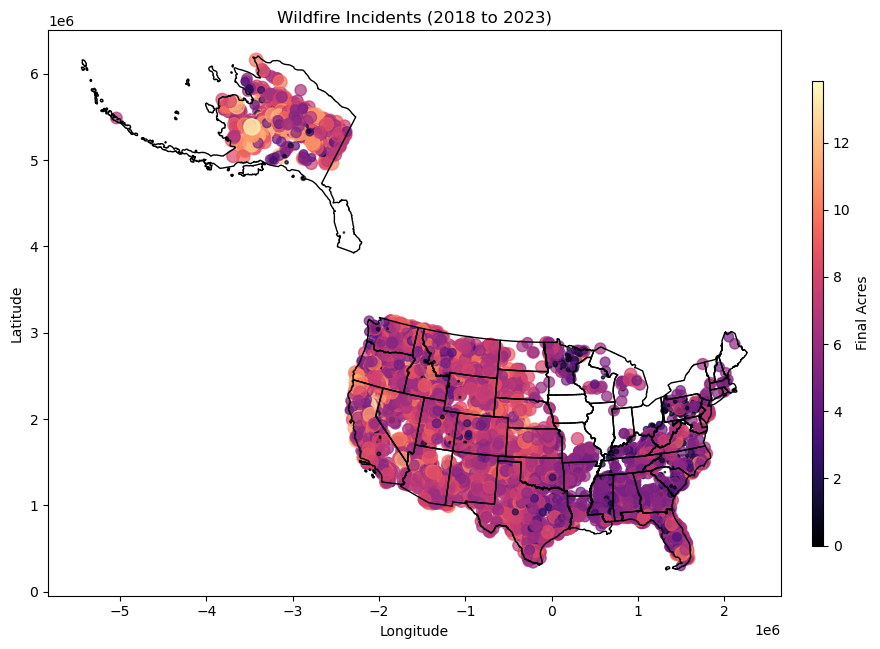

279

In [9]:
# Filter the GeoDataFrame for points in Colorado
gdf = incidents_gdf.copy()
gdf['log_FINAL_ACRS'] = np.log1p(gdf['FINAL_ACRES'])  # log1p to handle log(0) issues

# Plot the points on a map, with size based on FINAL_ACRES
fig, ax = plt.subplots(figsize=(10, 10))

# Normalize the FINAL_ACRES values for color mapping
norm = colors.Normalize(vmin=gdf['log_FINAL_ACRS'].min(), vmax=gdf['log_FINAL_ACRS'].max())

# Plot the points with size and color based on FINAL_ACRES
gdf.plot(ax=ax, marker='o',
         markersize=gdf['log_FINAL_ACRS'] * 10,  # Adjust the scaling factor as needed
         color=gdf['log_FINAL_ACRS'].apply(lambda x: cm.magma(norm(x))),
         alpha=0.7)

states.plot(ax=ax, edgecolor='black', linewidth=1, color='none')

# Set title and labels
plt.title('Wildfire Incidents (2018 to 2023)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.015, pad=0.04, aspect=40)
cbar.set_label('Final Acres')

# Display the plot
plt.show()

del gdf
gc.collect()

In [ ]:
# Subset to western U.S. ecoregions

In [10]:
# Load western U.S. ecoregions
fp = os.path.join(projdir,'data/spatial/mod/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','geometry']]
ecol3 = ecol3.rename(columns={'NA_L3NAME': 'na_l3name'})
ecol3.columns

Index(['na_l3name', 'geometry'], dtype='object')

In [11]:
# Perform the overlay analysis
incidents_west = gpd.overlay(incidents_gdf, ecol3, how='intersection') # find overlaps
print(f"There are {len(incidents_west)} ICS-209-PLUS incidents across western U.S. ecoregions in CONUS (2018-2023).")

There are 3935 ICS-209-PLUS incidents across western U.S. ecoregions in CONUS (2018-2023).


In [ ]:
# Save this file out.

In [12]:
out_dir = os.path.join(projdir, 'data/spatial/raw/ICS209PLUS/')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
out_file = os.path.join(out_dir, 'wf_incidents_spatial_west_2018to2023.gpkg')
incidents_west.to_file(out_file)
print(f"file exported to {out_file}")

file exported to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/raw/ICS209PLUS/wf_incidents_spatial_west_2018to2023.gpkg


In [ ]:
# Load the NIFC fire perimeters (aspen fires) and find nearest neighbors.

In [13]:
aspen_events_fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-interagency_2018_to_2023-EVT-aspen.gpkg')
aspen_events = gpd.read_file(aspen_events_fp)
aspen_events['FIRE_YEAR'] = aspen_events['FIRE_YEAR'].astype(int)
aspen_events.columns

Index(['OBJECTID', 'na_l3name', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR',
       'INCIDENT', 'FEATURE_CA', 'GIS_ACRES', 'pct_aspen', 'geometry'],
      dtype='object')

In [14]:
print(incidents_west.crs)
print(aspen_events.crs)

EPSG:5070
EPSG:5070


In [15]:
# Identify matching fired perimiters and ics-209 incident reports
ics_nn, no_matches = find_nearest(aspen_events, incidents_west, NN=10, max_dist=10000, max_size_diff=50)
print(f'Found {len(ics_nn)} matches;')

There were [90/298] fires with no matches.
Found 192 matches;


In [16]:
ics_nn.columns

Index(['Unnamed: 0', 'INCIDENT_ID', 'INCIDENT_NUMBER', 'INCIDENT_NAME',
       'INCTYP_ABBREVIATION', 'FINAL_ACRES', 'CAUSE', 'COMPLEX',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'EXPECTED_CONTAINMENT_DATE',
       'FATALITIES', 'FUEL_MODEL', 'INCIDENT_DESCRIPTION', 'INC_IDENTIFIER',
       'INJURIES_TOTAL', 'LL_CONFIDENCE', 'LL_UPDATE', 'LOCAL_TIMEZONE',
       'POO_CITY', 'POO_COUNTY', 'POO_LATITUDE', 'POO_LONGITUDE',
       'POO_SHORT_LOCATION_DESC', 'POO_STATE', 'PROJECTED_FINAL_IM_COST',
       'START_YEAR', 'SUPPRESSION_METHOD', 'STR_DAMAGED_TOTAL',
       'STR_DAMAGED_COMM_TOTAL', 'STR_DAMAGED_RES_TOTAL',
       'STR_DESTROYED_TOTAL', 'STR_DESTROYED_COMM_TOTAL',
       'STR_DESTROYED_RES_TOTAL', 'FATALITIES_RESPONDER', 'FATALITIES_PUBLIC',
       'FINAL_REPORT_DATE', 'INCIDENT_ID_OLD', 'INC_MGMT_NUM_SITREPS',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'STR_THREATENED_MAX',
       'STR_THREATENED_COMM_MAX', 'STR_THREATENED_RES_MAX', 'TOTAL_AERIAL_SUM',
       'TOTAL_PERSON

In [17]:
ics_nn_gdf = gpd.GeoDataFrame(ics_nn, geometry='geometry', crs=proj)
ics_nn_gdf = ics_nn_gdf[['NIFC_ID','NIFC_NAME','NIFC_ACRES','INCIDENT_ID','INCIDENT_NAME','START_YEAR','FINAL_ACRES',
                         'CAUSE','DISCOVERY_DATE','DISCOVERY_DOY','WF_CESSATION_DATE','WF_CESSATION_DOY',
                         'STR_DESTROYED_TOTAL','STR_DAMAGED_TOTAL','STR_THREATENED_MAX',
                         'EVACUATION_REPORTED','PEAK_EVACUATIONS','WF_PEAK_AERIAL','WF_PEAK_PERSONNEL',
                         'na_l3name', 'geometry']]
date_cols = ['DISCOVERY_DATE','WF_CESSATION_DATE']
for col in date_cols:
    ics_nn_gdf[col] = pd.to_datetime(ics_nn_gdf[col], errors='coerce')
ics_nn_gdf[['NIFC_ID','NIFC_NAME','NIFC_ACRES','INCIDENT_ID','INCIDENT_NAME','START_YEAR','FINAL_ACRES']].head()

,NIFC_ID,NIFC_NAME,NIFC_ACRES,INCIDENT_ID,INCIDENT_NAME,START_YEAR,FINAL_ACRES
0,6,DEVIL CREEK,20.46,2018_9105784_DEVIL CREEK,Devil Creek,2018,20.0
1,8,577,89.31,2019_10730561_577,577,2019,95.0
2,14,416,54130.98,2018_9091030_416,416,2018,54129.0
3,23,LOADING PEN,41.94,2020_11728107_LOADING PEN,Loading Pen,2020,42.0
4,24,PLATEAU,19677.32,2018_9223810_PLATEAU,Plateau,2018,19634.0


In [18]:
# Check for incident name matches
ics_nn_gdf['NIFC_NAME'] = ics_nn_gdf['NIFC_NAME'].str.upper()
ics_nn_gdf['INCIDENT_NAME'] = ics_nn_gdf['INCIDENT_NAME'].str.upper()
ics_nn_gdf['FIRE_NAME_MATCH'] = ics_nn_gdf['NIFC_NAME'] == ics_nn_gdf['INCIDENT_NAME']
print(f"There are [{ics_nn_gdf['FIRE_NAME_MATCH'].sum()}/{len(ics_nn_gdf)}] matching incidents names !")

There are [187/192] matching incidents names !


In [19]:
out_fp = os.path.join(projdir,'data/spatial/mod/ICS209PLUS/')
if not os.path.exists(out_fp):
    os.makedirs(out_fp)
out_fp = os.path.join(out_fp,'ics209plus_aspen_fires.gpkg')
ics_nn_gdf.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/ICS209PLUS/ics209plus_aspen_fires.gpkg


In [20]:
# Save out NIFC fires with ICS matches
matches = ics_nn_gdf['NIFC_ID'].unique()
aspen_events_ = aspen_events[aspen_events['OBJECTID'].isin(matches)]
print(len(aspen_events_))
print(aspen_events_.columns)

192
Index(['OBJECTID', 'na_l3name', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR',
       'INCIDENT', 'FEATURE_CA', 'GIS_ACRES', 'pct_aspen', 'geometry'],
      dtype='object')


In [21]:
# Drop the geometry column from the ICS data
ics_nn_gdf_ = ics_nn_gdf.drop(columns=['FIRE_NAME_MATCH','na_l3name','geometry'])
ics_nn_gdf_.columns

Index(['NIFC_ID', 'NIFC_NAME', 'NIFC_ACRES', 'INCIDENT_ID', 'INCIDENT_NAME',
       'START_YEAR', 'FINAL_ACRES', 'CAUSE', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'WF_CESSATION_DATE', 'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL',
       'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX', 'EVACUATION_REPORTED',
       'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL'],
      dtype='object')

In [22]:
# Join perimeter data to ICS-209-PLUS
aspen_events_ics = pd.merge(aspen_events_, ics_nn_gdf_, left_on='OBJECTID', right_on='NIFC_ID', how='inner')
aspen_events_ics.columns

Index(['OBJECTID', 'na_l3name', 'MAP_METHOD', 'GEO_ID', 'IRWINID', 'FIRE_YEAR',
       'INCIDENT', 'FEATURE_CA', 'GIS_ACRES', 'pct_aspen', 'geometry',
       'NIFC_ID', 'NIFC_NAME', 'NIFC_ACRES', 'INCIDENT_ID', 'INCIDENT_NAME',
       'START_YEAR', 'FINAL_ACRES', 'CAUSE', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'WF_CESSATION_DATE', 'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL',
       'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX', 'EVACUATION_REPORTED',
       'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL'],
      dtype='object')

In [25]:
# Tidy the columns
aspen_events_ics = aspen_events_ics[[
    'NIFC_ID', 'NIFC_NAME', 'NIFC_ACRES', 'FINAL_ACRES', 'pct_aspen',
    'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR',  'CAUSE', 
    'DISCOVERY_DATE', 'DISCOVERY_DOY','WF_CESSATION_DATE', 'WF_CESSATION_DOY', 
    'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX', 
    'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 
    'na_l3name', 'geometry']]
aspen_events_ics.head(10)

,NIFC_ID,NIFC_NAME,NIFC_ACRES,FINAL_ACRES,pct_aspen,INCIDENT_ID,INCIDENT_NAME,START_YEAR,CAUSE,DISCOVERY_DATE,...,WF_CESSATION_DOY,STR_DESTROYED_TOTAL,STR_DAMAGED_TOTAL,STR_THREATENED_MAX,EVACUATION_REPORTED,PEAK_EVACUATIONS,WF_PEAK_AERIAL,WF_PEAK_PERSONNEL,na_l3name,geometry
0,6,DEVIL CREEK,20.46,20.0,29.181495,2018_9105784_DEVIL CREEK,DEVIL CREEK,2018,L,2018-07-19 15:46:00,...,202.0,0.0,0.0,NaN,NaN,NaN,NaN,15.0,Southern Rockies,"POLYGON ((-981843.637 1646044.004, -981847.953..."
1,8,577,89.31,95.0,2.408112,2019_10730561_577,577,2019,L,2019-07-28 14:22:00,...,230.0,0.0,0.0,NaN,NaN,NaN,5.0,60.0,Southern Rockies,"POLYGON ((-1004520.269 1629060.825, -1004522.5..."
2,14,416,54130.98,54129.0,38.614463,2018_9091030_416,416,2018,U,2018-06-01 11:02:00,...,184.0,0.0,0.0,3386.0,True,2182.0,15.0,429.125,Southern Rockies,"MULTIPOLYGON (((-1047907.942 1672642.863, -104..."
3,23,LOADING PEN,41.94,42.0,17.099567,2020_11728107_LOADING PEN,LOADING PEN,2020,L,2020-06-13 21:42:00,...,170.0,0.0,0.0,NaN,NaN,NaN,3.0,78.5,Southern Rockies,"POLYGON ((-1071762.330 1683114.574, -1071762.9..."
4,24,PLATEAU,19677.32,19634.0,1.305924,2018_9223810_PLATEAU,PLATEAU,2018,L,2018-07-22 16:18:00,...,229.0,0.0,0.0,NaN,NaN,NaN,4.0,143.6,Southern Rockies,"POLYGON ((-1094448.086 1686999.388, -1094448.7..."
5,26,PLUMTAW,721.4,721.0,70.241348,2022_14542839_PLUMTAW,PLUMTAW,2022,U,2022-05-17 13:49:00,...,138.0,0.0,0.0,75.0,True,200.0,4.5,242.666667,Southern Rockies,"POLYGON ((-969787.326 1648469.699, -969792.261..."
6,33,DOE CANYON,2559.52,2560.0,8.358058,2019_10738675_DOE CANYON,DOE CANYON,2019,L,2019-06-20 14:41:00,...,184.0,0.0,0.0,NaN,NaN,NaN,NaN,44.0,Southern Rockies,"POLYGON ((-1104275.303 1705190.773, -1104275.0..."
7,43,CHRIS MOUNTAIN,510.51,511.0,1.574569,2023_15990891_CHRIS MOUNTAIN,CHRIS MOUNTAIN,2023,L,2023-06-28 15:57:00,...,185.0,0.0,0.0,7.0,True,2.0,7.0,293.178571,Southern Rockies,"POLYGON ((-984454.113 1641237.622, -984454.991..."
8,44,DRY LAKE,1372.3,1372.0,14.827318,2023_16030033_DRY LAKE,DRY LAKE,2023,U,2023-08-01 10:04:00,...,217.0,0.0,0.0,NaN,NaN,NaN,1.0,96.0,Southern Rockies,"POLYGON ((-999392.712 1642605.081, -999393.216..."
9,45,BEAR CREEK,1102.97,1102.0,35.344828,2023_16010727_BEAR CREEK,BEAR CREEK,2023,L,2023-07-28 14:44:00,...,253.0,0.0,0.0,3.0,NaN,NaN,1.0,85.833333,Southern Rockies,"MULTIPOLYGON (((-988843.179 1669227.920, -9888..."


In [26]:
out_fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-ics_2018_to_2023-aspen.gpkg')
aspen_events_.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/NIFC/nifc-ics_2018_to_2023-aspen.gpkg
